In [1]:
!CUDA_VISIBLE_DEVICE=0

Before running the following code, ensure that you have trained the VAE model, the diffusion model, and the classifier model.

Given an AnnData file you wish to analyze, named `anndata.h5ad`, please follow these steps in your command line to create the necessary input data:

1. **Train VAE**:
   - Prior to training, create the folder `path/to/saved_VAE_model`.
   - In the terminal, navigate to the `VAE` directory:
     ```bash
     cd VAE
     ```
   - Run the following command to train the Autoencoder:
     ```bash
     echo "Training Autoencoder, this might take a long time" 
     CUDA_VISIBLE_DEVICES=0 python VAE_train.py --data_dir 'path/to/anndata.h5ad' --num_genes 18996 --save_dir 'path/to/saved_VAE_model' --max_steps 200000
     echo "Training Autoencoder done"
     ```
**Example**
One needs to download the data as specified in the paper and make sure to unzip everything. Training the encoder is done by the following terminal command.

 

```python
cd VAE
echo "Training Autoencoder, this might take a long time"
CUDA_VISIBLE_DEVICES=0 python VAE_train.py --data_dir '/workspace/projects/001_scDiffusion/data/data_in/tabula_muris/all.h5ad' --num_genes 18996 --state_dict "/workspace/projects/001_scDiffusion/scripts/scDiffusion/annotation_model_v1" --save_dir '../checkpoint/AE/my_VAE' --max_steps 200000 --max_minutes 15
echo "Training Autoencoder done"
```

Where the unzipped muris data was unzipped at

```python
'/workspace/projects/001_scDiffusion/data/data_in/tabula_muris/all.h5ad'
```

And the SCimilarity weights were downloaded and unzipped at 

```python
'/workspace/projects/001_scDiffusion/scripts/scDiffusion/annotation_model_v1'
```

2. **Train the Diffusion Model**:
   - Prior to training, create the folder `path/to/saved_diffusion_model`.
   - In the terminal, navigate back to the root directory:
     ```bash
     cd ..
     ```
   - Run the following command to train the diffusion backbone:
     ```bash
     echo "Training diffusion backbone"
     CUDA_VISIBLE_DEVICES=0 python cell_train.py --data_dir 'path/to/anndata.h5ad'  --vae_path 'path/to/saved_VAE_model/VAE_checkpoint.pt' \
         --save_dir 'path/to/saved_diffusion_model' --model_name 'my_diffusion' --save_interval 20000
     echo "Training diffusion backbone done"
     ```

3. **Train the Classifier**:
   - Prior to training, create the folder `path/to/saved_classifier_model`.
   - Run the following command to train the classifier:
     ```bash
     echo "Training classifier"
     CUDA_VISIBLE_DEVICES=0 python classifier_train.py --data_dir 'path/to/anndata.h5ad' --model_path "path/to/saved_classifier_model" \
         --iterations 40000 --vae_path 'path/to/saved_VAE_model/VAE_checkpoint.pt'
     echo "Training classifier, done"
     ```

Once the models are trained, you need to create the `.npz` files which will serve as input for the following steps. To do this:

1. **Unconditional Sampling (Generate Data from Diffusion Model)**:
   - Prior to sampling, create the folder `path/to/saved_unconditional_sampling`.
   - Run the following command to perform unconditional sampling:
     ```bash
     # Unconditional sampling
     python cell_sample.py --model_path "path/to/saved_diffusion_model/checkpoint.pt" --sample_dir "path/to/saved_unconditional_sampling"
     ```

2. **Conditional Sampling (Generate Data from Classifier Model)**:
   - Prior to sampling, create the folder `path/to/saved_conditional_sampling`.
   - You also need to modify the `main()` function in `classifier_sample.py` to create the samples based on your specified condition. **NEEDS MORE DOCUMENTATION: PROVIDE CLEAR EXAMPLE**
   - Run the following command to perform conditional sampling:
     ```bash
     # Conditional sampling 
     python classifier_sample.py --model_path "path/to/saved_diffusion_model/checkpoint.pt" --classifier_path "path/to/saved_classifier_model/checkpoint.pt" --sample_dir "path/to/saved_conditional_sampling"
     ```

Ensure that you replace `'path/to/anndata.h5ad'`, `'path/to/saved_VAE_model'`, `'path/to/saved_diffusion_model'`, and `'path/to/saved_classifier_model'` with the actual paths in your system. Additionally, make sure to adjust any other parameters according to your specific setup and requirements.

In [10]:
### CHANGE ACCORDING TO YOUR FILE SYSTEM ###
path_to_anndata = '/data1/lep/Workspace/guided-diffusion/data/tabula_muris/all.h5ad'
path_to_saved_VAE_model = '/data1/lep/Workspace/guided-diffusion/VAE/checkpoint/muris_scimilarity_lognorm_finetune/model_seed=0_step=150000.pt'
path_to_unconditional_sample = '/data1/lep/Workspace/guided-diffusion/output/muris_scimilarity.npz'
# In a later cell, also modify the path to the conditionally generated samples. 

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats
import torch
import sys
sys.path.append('..')
from VAE.VAE_model import VAE

UMAP

In [4]:
def load_VAE():
    autoencoder = VAE(
        num_genes=18996,
        device='cpu',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load(path_to_saved_VAE_model, map_location=torch.device('cpu')))
    return autoencoder

Load real data

In [7]:
adata = sc.read_h5ad(path_to_anndata)

adata = adata[np.where(adata.obs['celltype'].values.isnull()==0)[0]][::5]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

gene_names = adata.var_names

celltype = adata.obs['celltype']
real_data = adata.X.toarray()
real_data.shape

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


(11401, 18996)

Load unconditionally generated data

In [11]:
npzfile=np.load(path_to_unconditional_sample,allow_pickle=True)
cell_gen_all = npzfile['cell_gen'][::]

autoencoder = load_VAE()
gen_data = autoencoder(torch.tensor(cell_gen_all),return_decoded=True).cpu().detach().numpy()

gen_data.shape

(3000, 18996)

Plot UMAP

In [12]:
adata = np.concatenate((real_data, gen_data),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)

#adata.obs['celltype'] = np.concatenate((celltype, gen_class))
adata.obs['cell_name'] = [f"real" for i in range(real_data.shape[0])]+[f"generated" for i in range(gen_data.shape[0])]

In [13]:
# the data is already log norm
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


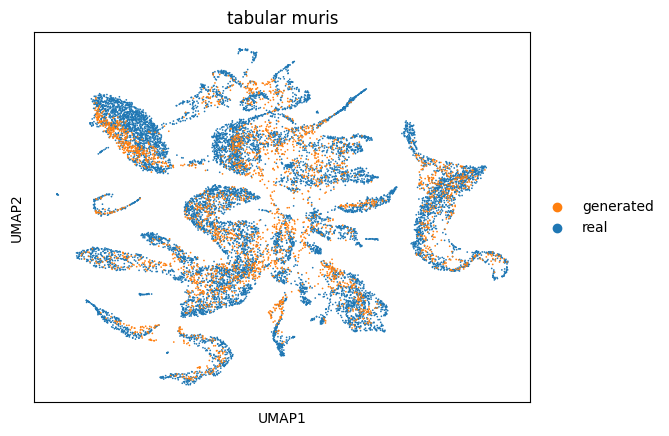

In [14]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata=adata,color="cell_name",size=6,title='tabular muris',palette={"real":"tab:blue", "generated":"tab:orange"})

Load conditionally generated data

In [15]:
path_to_conditional_sample = '../../output/cond_sampled/'

Load real data

In [16]:

adata = sc.read_h5ad(path_to_anndata)

adata = adata[np.where(adata.obs['celltype'].values.isnull()==0)[0]][::5]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

gene_names = adata.var_names

real_data_cell_type = adata.obs['celltype']
real_data = adata.X.toarray()
real_data.shape

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


(11401, 18996)

Load generated data

In [17]:
gen_data = []
gen_data_cell_type = []
tissues = ['Bladder', 'Heart_and_Aorta', 'Kidney', 'Limb_Muscle', 'Liver',
       'Lung', 'Mammary_Gland', 'Marrow', 'Spleen', 'Thymus', 'Tongue',
       'Trachea']
for tissue in tissues:
    npzfile=np.load(f'{path_to_conditional_sample}/tissue_{tissue}.npz',allow_pickle=True)
    number_of_cells = adata[adata.obs['celltype']==tissue].X.shape[0]
    gen_data.append(npzfile['cell_gen'][:number_of_cells])#.squeeze(1)

    gen_data_cell_type+=['gen '+tissue]*number_of_cells

gen_data = np.concatenate(gen_data,axis=0)

autoencoder = load_VAE()
gen_data = autoencoder(torch.tensor(gen_data),return_decoded=True).cpu().detach().numpy()

Prepare data

In [18]:
adata = np.concatenate((real_data, gen_data),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)

adata.obs['cell_type'] = np.concatenate((real_data_cell_type, gen_data_cell_type))
adata.obs['data_type'] = [f"real" for i in range(real_data.shape[0])]+[f"generated" for i in range(gen_data.shape[0])]

# the data is already log norm
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an undersco

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an undersco

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an undersco

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an undersco

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an undersco

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an undersco

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an undersco

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an undersco

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an undersco

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an undersco

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an undersco

/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/Caskroom/miniconda/base/envs/scDiffusion/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an undersco

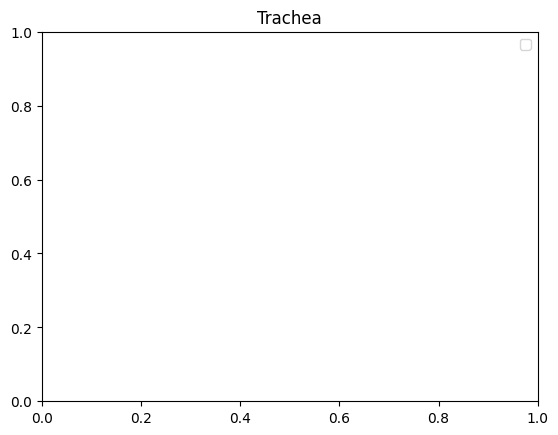

In [19]:
for tissue in tissues:
    color_dict = {}
    for cat in np.unique(adata.obs['cell_type'].values):
        if cat == tissue:
            color_dict[cat] = 'tab:orange'
        elif cat == 'gen '+tissue:
            color_dict[cat] = 'tab:blue'
        else:
            color_dict[cat] = 'black'
    sc.pl.umap(adata=adata,color="cell_type",groups=[tissue,'gen '+tissue],size=8, palette=color_dict, show = False, save=tissue+".pdf")
    plt.legend(loc = 'upper right')
    plt.title(tissue)